### Reference
* https://github.com/hyunwoongko/transformer

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

# Pytorch로 모델 속 확인하기

### Positional Encoding
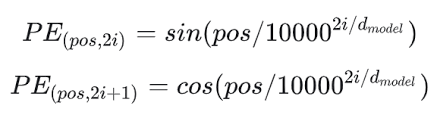

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len, device):
    '''
    d_model : dimension of model
    max_len : max sequence length
    '''
    super(PositionalEncoding, self).__init__()
    
    # input 사이즈와 똑같이 만들어줌
    self.encoding = torch.zeros(max_len, d_model, device=device)
    self.encoding.requires_grad = False

    # 1차원에서 2차원으로 만들어줌
    pos = torch.arange(0, d_model, device=device)
    pos = pos.float().unsqueeze(dim=1)

    _2i = toch.arange(0, d_model, step=2, device=device).float()

    self.encoding[:, 0::2] = torch.sin(pos / (10000**(_2i/ d_model)))
    self.encoding[:, 1::2] = torch.cos(pos / (10000**(_2i/ d_model)))

  def forward(self, x):
    batch_size, sequence_len = x.size()
    # batch_size: 128 / sequence_len: 30 / d_model: 512

    return self.encoding[:sequence_len, :] # [128,30,512]

### Multi-Head Attention
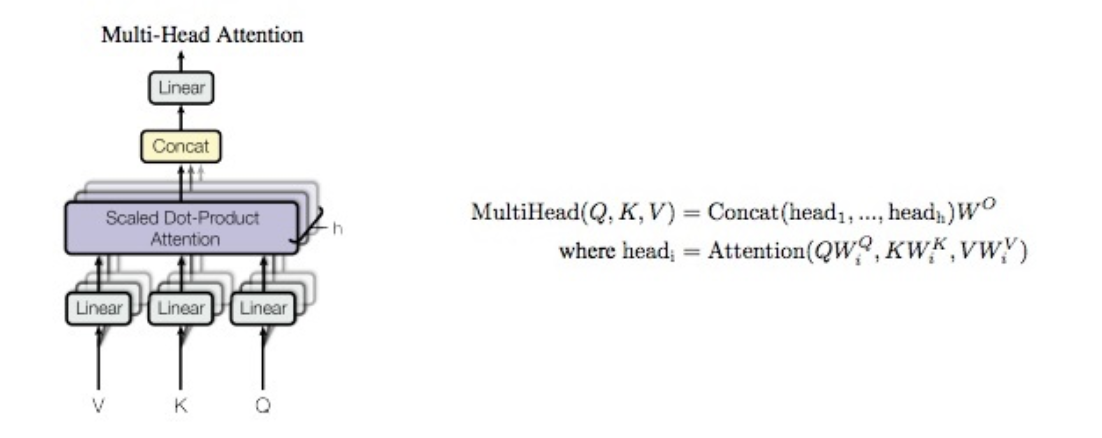

In [6]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_head):
    super(MultiHeadAttention, self).__init__()

    self.n_head = n_head

    self.attention = ScaleDotProductAttention()
    self.w_q = nn.Lienar(d_moedl, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Lienar(d_model, d_model)
    self.w_concat = nn.Linear(d_model, d_model)
  

  def split(self, tensor):
    '''
    n_head수에 맞게 dk를 조정 
    d_model / n_head = dk
    '''
    batch_size, length, d_model = tensor.size()

    d_k = d_model // self.n_head
    tensor = tensor.view(batch_size, self.n_head, length, d_k)
    
    return tensor

  
  def concat(self, tensor):
    '''
    input = [batch_size, head, length, d_tensor] 을
    output =[batch_size, length, d_model] 로 concat 함
    '''
    batch_size, head, length, d_tensor = tensor.size()
    d_model = head * d_tensor

    tensor = tensor.view(batch_size, length, d_model)
    return tensor


  def forward(self, q, k, v, mask=None):
    # 1) qeury / key / value로 dot product를 해줌
    q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

    # 2) head수에 맞게 qeury / key / value를 분리해줌
    q, k, v = self.split(q), self.split(k), self.split(v)

    # 3) self attention을 통해 단어들 끼리의 상관성을 학습함
    out, attention = self.attention(q, k, v, mask=mask)

    # 4) concat and pass linear layers
    out = self.concat(out)
    out = self.w_concat(out)

    # 5) visualize attention map
    return out

# Scaled Dot Product Attention
* (self attetion)
* q k v 를 받아서 attention을 해줌
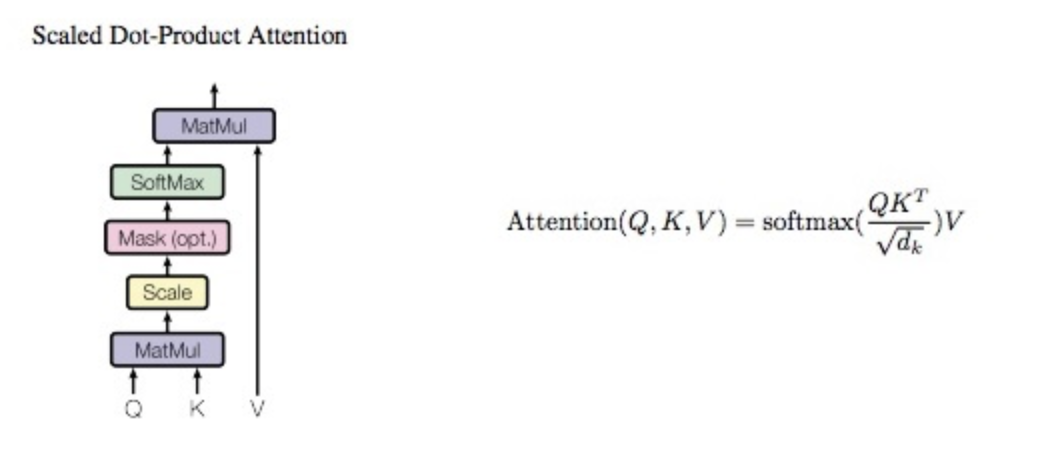

In [4]:
class ScaleDotProductAttention(nn.Module):
  def __init__(self):
    super(ScaleDotProductAttention, self).__init__()
    self.softmax = nn.Softmax()
  
  def forward(self, k, q, v, mask=None, e=1e-12):
    # input = [bach_size, head, lenght, d_tensor]
    bach_size, head, lenght, d_tensor = k.size()

    # 1) dot product Query with Key^T (단어별 유사도를 구함)
    k_t = k.view(batch_size, head, d_tensor, length)
    score = np.dot(q, k_t) / np.sqrt(d_tensor)

    # 2) mask 적용
    if mask is not None:
      score = score.masked_fill(mask ==0, -e)
    
    # 3) softmax 적용
    score = self.softmax(score)

    # 4) multiply with value
    v =np.dot(score, v)

    return v, score    

### Layer Norm
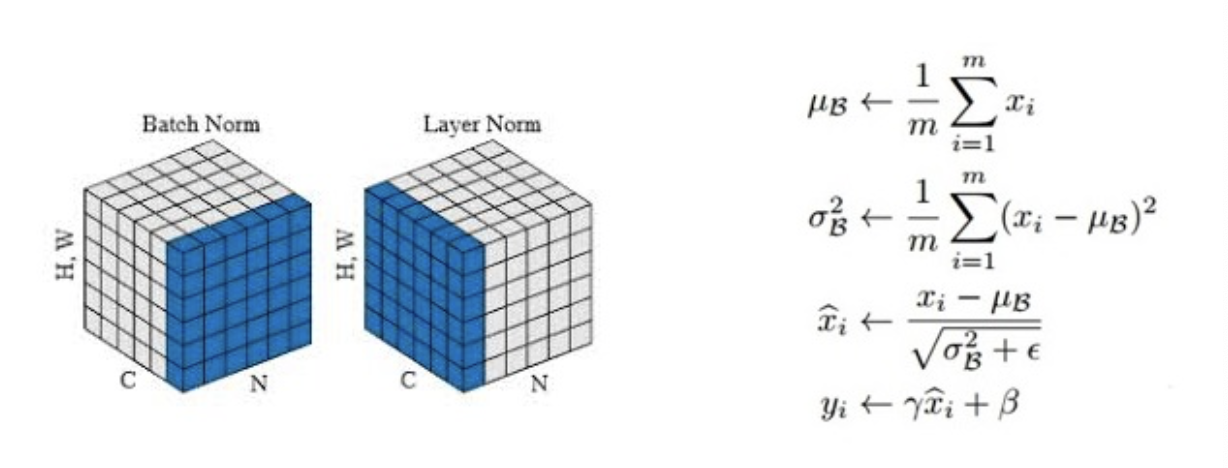

In [7]:
class LayerNorm(nn.Module):
  def __init__(self, d_model, eps=1e-12):
    super(LayerNorm, self).__init__()
    self.gamma = nn.Parameter(torch.ones(d_model))
    self.beta = nn.Parameter(torch.ones(d_model))
    self.eps = eps
  
  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)

    out = (x - mean) / (std + self.eps)
    out = self.gamma * out + self.beta
    return out

### Position Wise Feed Forward
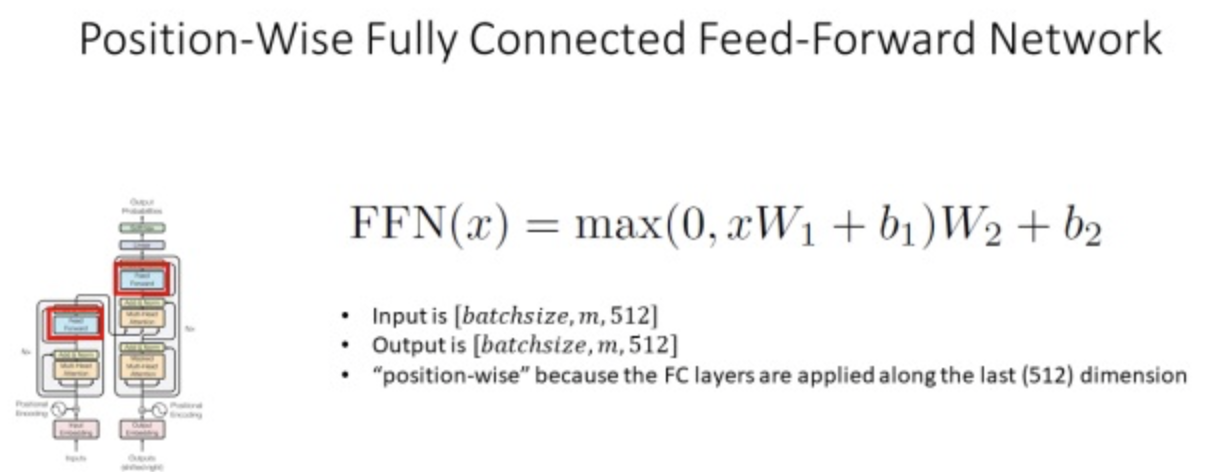

In [8]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, hidden, drop_prob=0.1):
    super(PositionwiseFeedForward, self).__init__()

    self.linear1 = nn.Linear(d_model, hidden)
    self.linear2 = nn.Linear(hidden, d_model)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=drop_prob)
  
  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x= self.dropout(x)

    x = self.linear2(x)
    return x

## Encoder & Decoder
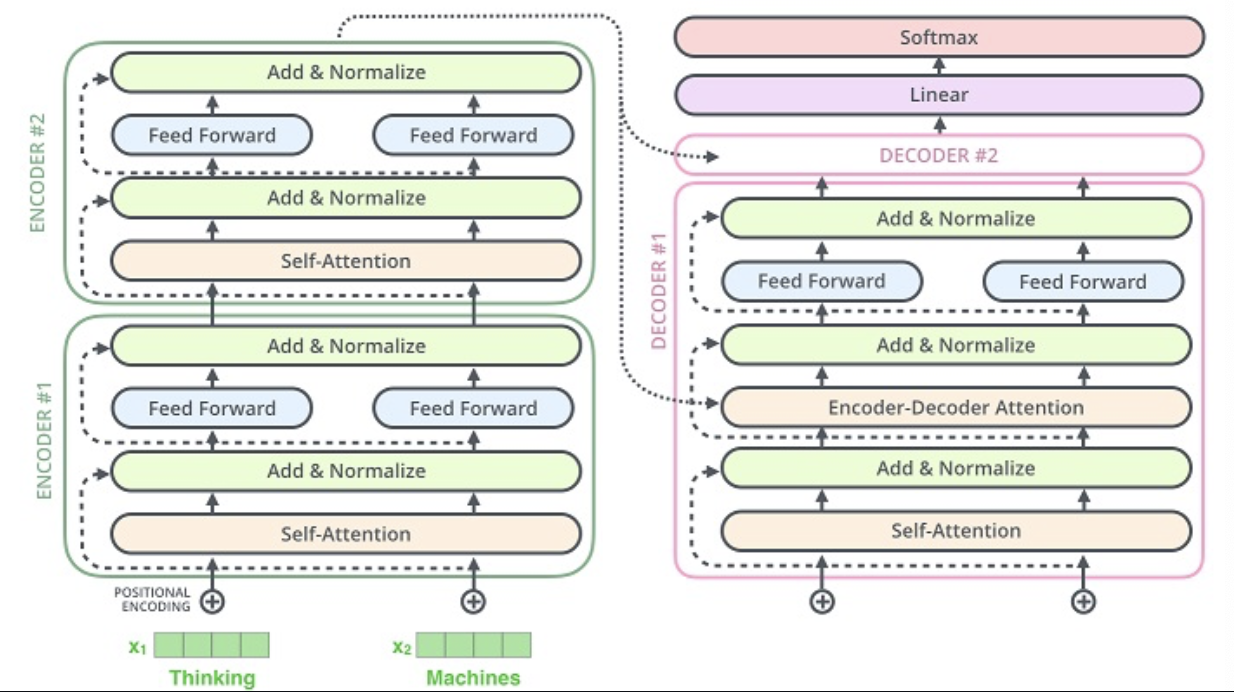

### Encoder

In [9]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
    super(EncoderLayer, self).__init__()

    self.attention = MultiHeadAttention(d_model, n_head)
    self.norm1 = LayerNorm(d_model)
    self.dropout1 = nn.Dropout(p=drop_prob)

    self.ffn = PositionwiseFeedForward(d_model, ffn_hidden, drop_prob)
    self.norm2 = LayerNorm(d_model)
    self.dropout2 = nn.Dropout(p=drop_prob)
  
  def forward(self, x, src_mask):
    # 1) self attention을 구함
    _x = x
    x = self.attention(q=x, k=x, v=x, mask=src_mask)

    # 2) add and norm
    x = self.norm1(x + _x)
    x = self.dropout1(x)

    # 3) positionwise feed forward network
    _x = x
    x = self.ffn(x)

    # 4) add and norm
    x = self.norm2(x + _x)
    x = self.dropout2(x)

    return x

In [11]:
class Encoder(nn.Module):
  def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_porb, device):
    super().__init__()

    self.emb = TransformerEmbedding(d_model=d_model,
                                    max_len=max_len,
                                    vocab_size=enc_voc_size,
                                    drop_prob=drop_prob,
                                    device=device)
    self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                              ffn_hidden=ffn_hidden,
                                              n_head=n_head,
                                              drop_prob=drop_prob)
      for _ in range(n_layers)])
    
  def forward(self, x, scr_mask):
    x = self.emb(x)
    
    for layer in self.layers:
      x = layer(x, src_mask)
  
    return x

### Decoder

In [12]:
class DecoderLatyer(nn.Module):
  def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
    super(DecoderLatyer, self).__init__()

    self.self_attention = MultiHeadAttention(d_model, n_head)
    self.norm1 = LayerNorm(d_model=d_model)
    self.dropout1 = nn.Dropout(p=drop_prob)

    self.enc_dec_attention = MultiHeadAttention(d_model, n_head)
    self.norm2 = LayerNorm(d_model=d_model)
    self.dropout2 = nn.Dropout(p=drop_prob)

    self.ffn = PointwiseFeedForward(d_model, ffn_hidden, drop_prob)
    self.norm3 = LayerNorm(d_model=d_model)
    self.dropout3 = nn.Dropout(p=drop_prob)
  
  def forward(self, dec, enc, trg_mask, src_mask):
    # 1) self attention을 궇마
    _x = dec
    x = self.self_attention(q=dec, k=dec, v=dec, mask=trg_mask)

    # 2) add and norm
    x = self.norm1(x + _x)
    x = self.dropout1(x)

    if enc is not None:
      # 3) 디코더의 값을 인코더의 최종 출력과 attention함
      _x = x
      x = self.enc_dec_attention(q=x, k=enc, v=enc, mask=src_mask)

      # 4) add and norm
      x = self.norm2(x + _x)
      x = self.dropout2(x)

    # 5) positionwise feed forward network
    _x = x
    x = self.ffn(x)

    # 6) add and norm
    x = self.norm3(x + _x)
    x = self.dropout3(x)

    return x

In [13]:
class Decoder(nn.Module):
  def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
    super().__init__()
    self.emb = TransformerEmbedding(d_model=d_model,
                                    max_len=max_len,
                                    vocab_size=dec_voc_size,
                                    drop_prob=drop_prob,
                                    device=device)
    self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                              ffn_hidden=ffn_hidden,
                                              n_head=n_head,
                                              drop_prob=drop_prob)
      for _ in range(n_layers)])
    self.linear = nn.Linear(d_model, dec_voc_size)

  def forward(self, trg, src, trg_mask, src_mask):
    trg = self.emb(trg)

    for layer in self.layers:
      trg = layer(trg, src, trg_mask, src_mask):
    
    output = self.lienar(trg)
    return output

SyntaxError: ignored